In [1]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, ttest_ind
import scipy.stats as stats
import gc

import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_pvalue_ecdf(pvalues: float, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.plot([0,1],[0,1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.grid()

In [3]:
def get_minimal_determinable_effect(std, sample_size, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    disp_sum_sqrt = (2 * (std ** 2)) ** 0.5
    mde = (t_alpha + t_beta) * disp_sum_sqrt / np.sqrt(sample_size)
    return mde

In [4]:
def check_ttest(a, b, alpha=0.05):
    """Тест Стьюдента. Возвращает 1, если отличия значимы."""
    _, pvalue = ttest_ind(a, b)
    return int(pvalue < alpha)

# Task description
В таблице приведены данные за 3 дня АБ-теста, в котором тестировался алгоритм рекомендаций на главной странице сайта. Необходимо составить список метрик для выбора группы из доступных данных. Одна метрика обязательна — среднее время просмотра видео активными пользователями (суммарный watch_time) на сайте за день. Для каждой метрики необходимо проверить её корректность, рассчитать детектируемый относительный эффект (uplift), статистическую значимость и MDE. Решение следует принимать отдельно для desktop и mobile.

Данные:
 * date - время события
 * uid - user_id
 * exp_group - группа АБ (a, b)
 * event_type - тип события
 * platform - плотформа (desktop, mobile)
 * watch_time - время просматра в секундах, кратное 30, если event_type='watch_time' (30, 60, 90, ...)

# Settings

In [5]:
sns.set_theme()

# Data mining

In [6]:
try:
    data = pd.read_parquet('data.parquet')
except FileNotFoundError:
    data = pd.read_clipboard()

assert len(data) == 187475844, 'should be 187 475 844 rows'
assert data['uid'].count() == 187475844, 'should be 187 475 844 total'
data['date'] = pd.to_datetime(data['date'])
data['dt_date'] = data['date'].dt.date
data.head()

,date,uid,exp_group,event_type,platform,watch_time,dt_date
0,2024-08-21 19:13:55,15032293015989291181,a,dislike,mobile,0,2024-08-21
1,2024-08-21 05:51:56,14931690330411294856,a,dislike,mobile,0,2024-08-21
2,2024-08-21 11:06:42,15779543079323779910,a,dislike,mobile,0,2024-08-21
3,2024-08-21 14:21:55,17935115796138604631,b,dislike,mobile,0,2024-08-21
4,2024-08-21 04:06:43,10944583879122285809,a,dislike,mobile,0,2024-08-21


In [7]:
# ===========================================
# 0. Удаляем отрицательный watch_time
# ===========================================
print("0) Удаляем записи с отрицательным watch_time...")
data = data[data['watch_time'] >= 0]

for col in ['exp_group', 'platform', 'event_type']:
    data[col] = data[col].astype('category')


# ===========================================
# 1. Склеиваем дубли по ключам, усредняя watch_time
#    (один groupby вместо dup_mask + merge)
# ===========================================
print("1) Аггрегируем дубли по ключам (берём средний watch_time)...")

keys = ['uid', 'exp_group', 'date', 'event_type', 'platform']

data = (
    data
    .groupby(keys, as_index=False, observed=True, sort=False)
    .agg({'watch_time': 'mean'})
)

print("Размер после аггрегации дублей:", data.shape)


# ===========================================
# 2. Удаляем дубли между платформами
#    (один и тот же uid+date+event_type на двух платформах)
# ===========================================
print("2) Удаляем события, задублированные между платформами...")

data = (
    data
    .sort_values('platform')  
    .drop_duplicates(subset=['uid', 'date', 'event_type'], keep='first')
)

print("Размер после удаления межплатформенных дублей:", data.shape)


# ===========================================
# 3. Удаляем пользователей, попавших сразу в несколько групп
#    (по uid+platform+date несколько exp_group)
#    Используем transform вместо отдельного df + merge
# ===========================================
print("3) Удаляем пользователей, попавших сразу в обе группы...")

grp_counts = (
    data
    .groupby(['uid', 'platform', 'date'])['exp_group']
    .transform('nunique')
)

mask_conflict = grp_counts > 1
n_conflict_rows = mask_conflict.sum()
n_conflict_users = data.loc[mask_conflict, 'uid'].nunique()
print(f"Строк с конфликтами групп: {n_conflict_rows:,}")
print(f"Пользователей с конфликтами: {n_conflict_users:,}")

data = data[~mask_conflict]
print("Размер после удаления конфликтов групп:", data.shape)


# ===========================================
# 4. Удаляем аномальные дни (>24 часов просмотра)
#    Считаем сумму watch_time по uid×dt_date и режем всё,
#    где > 24 часов (по секундам)
# ===========================================
print("4) Удаляем аномальные дни с >24 часов просмотра...")

SECONDS_IN_DAY = 24 * 3600

if 'dt_date' not in data.columns:
    data['dt_date'] = data['date'].dt.date

# считаем только по событиям просмотра; остальным начисляем 0
wt_per_row = np.where(data['event_type'] == 'watch_time', data['watch_time'], 0)

total_watch_per_day = (
    data
    .assign(_wt=wt_per_row)
    .groupby(['uid', 'dt_date'])['_wt']
    .transform('sum')
)

mask_normal = total_watch_per_day <= SECONDS_IN_DAY
n_anomaly_rows = (~mask_normal).sum()
n_anomaly_users = data.loc[~mask_normal, 'uid'].nunique()

print(f"Строк с аномалиями (>24h): {n_anomaly_rows:,}")
print(f"Пользователей с аномальными днями: {n_anomaly_users:,}")

data = data[mask_normal].drop(columns=[])  
print("Размер после удаления аномальных дней:", data.shape)


print("\n=== ✔ Очистка завершена ===")
print("Итоговый размер датафрейма:", data.shape)

0) Удаляем записи с отрицательным watch_time...
1) Аггрегируем дубли по ключам (берём средний watch_time)...
Размер после аггрегации дублей: (187445982, 6)
2) Удаляем события, задублированные между платформами...
Размер после удаления межплатформенных дублей: (187445951, 6)
3) Удаляем пользователей, попавших сразу в обе группы...
Строк с конфликтами групп: 6
Пользователей с конфликтами: 3
Размер после удаления конфликтов групп: (187445945, 6)
4) Удаляем аномальные дни с >24 часов просмотра...
Строк с аномалиями (>24h): 19,049
Пользователей с аномальными днями: 99
Размер после удаления аномальных дней: (187426896, 7)

=== ✔ Очистка завершена ===
Итоговый размер датафрейма: (187426896, 7)


In [8]:
data['date'] = pd.to_datetime(data['date'])
data['dt_date'] = data['date'].dt.date
data['watch_time'] = data['watch_time'].astype('int32')
data['exp_group']  = data['exp_group'].astype('category')
data['platform']   = data['platform'].astype('category')
data['event_type'] = data['event_type'].astype('category')
data.head()

,uid,exp_group,date,event_type,platform,watch_time,dt_date
0,15032293015989291181,a,2024-08-21 19:13:55,dislike,mobile,0,2024-08-21
116403123,16302404176007163546,b,2024-08-23 09:16:56,watch_time,mobile,210,2024-08-23
116403124,14029232308510793645,b,2024-08-23 16:17:40,watch_time,mobile,30,2024-08-23
116403126,13066476364482745001,b,2024-08-23 17:06:09,watch_time,mobile,330,2024-08-23
116403127,5739915942946497302,b,2024-08-22 04:55:08,watch_time,mobile,90,2024-08-22


# EDA

In [9]:
# проверено
data[['uid', 'exp_group','date','event_type','platform']].duplicated().sum()

0

In [10]:
# проверено
data[['uid','date','event_type']].duplicated().sum()

0

In [11]:
# проверено
data[['uid','date','platform']].duplicated().sum()

152079

In [12]:
data[data.duplicated(subset=['uid', 'date','platform'], keep=False)].sort_values(['uid', 'date', 'event_type']).head()

,uid,exp_group,date,event_type,platform,watch_time,dt_date
19409801,23788185194692,b,2024-08-21 06:29:18,success_view,desktop,0,2024-08-21
89755457,23788185194692,b,2024-08-21 06:29:18,watch_time,desktop,30,2024-08-21
23264216,118633889149986,b,2024-08-21 08:59:24,success_view,mobile,0,2024-08-21
55743307,118633889149986,b,2024-08-21 08:59:24,watch_time,mobile,30,2024-08-21
5422148,361969495505659,b,2024-08-21 02:30:41,success_view,mobile,0,2024-08-21


In [13]:
data.describe()

,uid,watch_time
count,1.874269e+08,1.874269e+08
mean,9.225719e+18,1.293233e+02
std,5.324658e+18,1.948613e+02
min,2.957617e+11,0.000000e+00
25%,4.614153e+18,3.000000e+01
50%,9.226424e+18,6.000000e+01
75%,1.383783e+19,1.500000e+02
max,1.844674e+19,8.493000e+04


In [14]:
data['dt_date'].value_counts(dropna=False).apply(lambda x: f'{x:,}'.replace(',', ' '))

2024-08-21    77 365 247
2024-08-23    56 703 876
2024-08-22    53 357 773
Name: dt_date, dtype: object

In [15]:
data['platform'].value_counts(dropna=False).apply(lambda x: f'{x:,}'.replace(',', ' '))

mobile     141 925 804
desktop     45 501 092
Name: platform, dtype: object

In [16]:
data['event_type'].value_counts(dropna=False).apply(lambda x: f'{x:,}'.replace(',', ' '))

watch_time         158 882 870
success_view        26 598 281
favorite             1 174 942
like                   549 644
favorite_remove        160 613
dislike                 43 840
send_comment            16 706
Name: event_type, dtype: object

In [17]:
data['exp_group'].value_counts(dropna=False).apply(lambda x: f'{x:,}'.replace(',', ' '))

b    94 647 892
a    92 779 004
Name: exp_group, dtype: object

# Metrics

## DAU 

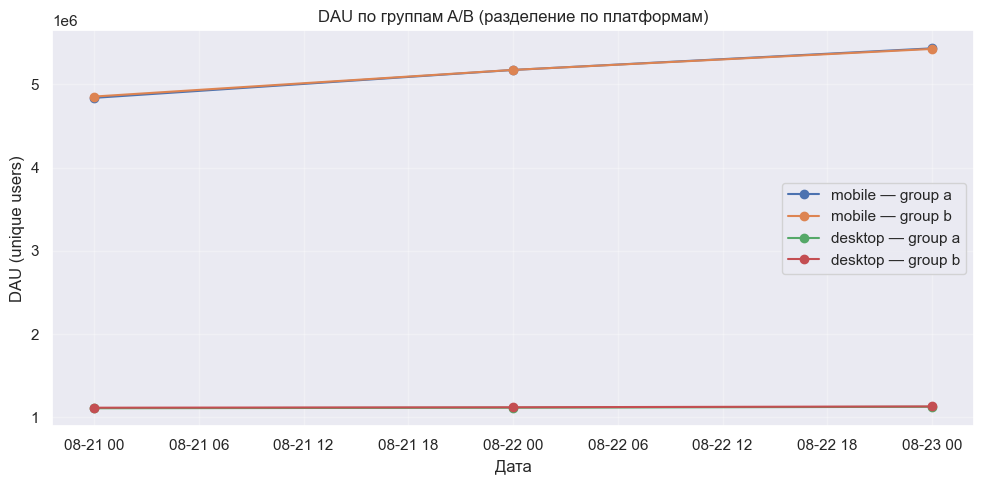

4323

In [18]:
dau = (
    data
    .groupby(['dt_date', 'platform', 'exp_group'])['uid']
    .nunique()
    .reset_index(name='dau')
)

plt.figure(figsize=(10, 5))

for platform in ['mobile', 'desktop']:
    subset = dau[dau['platform'] == platform]
    for group in subset['exp_group'].unique():
        plt.plot(
            subset[subset['exp_group'] == group]['dt_date'],
            subset[subset['exp_group'] == group]['dau'],
            marker='o',
            label=f"{platform} — group {group}"
        )

plt.title("DAU по группам A/B (разделение по платформам)")
plt.xlabel("Дата")
plt.ylabel("DAU (unique users)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

del dau
gc.collect()

## NPS

In [19]:
positive_events = ['success_view', 'like', 'favorite']
negative_events = ['dislike']

# Берём только нужные события и только нужные колонки
eng = data.loc[
    data['event_type'].isin(positive_events + negative_events),
    ['dt_date', 'uid', 'exp_group', 'platform', 'event_type']
].copy()

# ✅ Считаем количество событий через SeriesGroupBy + reset_index
eng_metrics = (
    eng
    .groupby(['dt_date', 'exp_group', 'platform', 'event_type'])['uid']
    .count()
    .reset_index(name='count')
)

# Поворот таблицы: столбцы = типы событий
eng_pivot = (
    eng_metrics
    .pivot_table(
        index=['dt_date', 'exp_group', 'platform'],
        columns='event_type',
        values='count',
        fill_value=0
    )
    .reset_index()
)

# Активные пользователи в день по группе и платформе
daily_users = (
    data
    .groupby(['dt_date', 'exp_group', 'platform'])['uid']
    .nunique()
    .reset_index(name='active_users')
)

# Мержим
eng_final = eng_pivot.merge(
    daily_users,
    on=['dt_date', 'exp_group', 'platform'],
    how='left'
)

# Гарантируем наличие колонок (на всякий случай, если какого-то события нет в данных)
for col in positive_events + negative_events:
    if col not in eng_final.columns:
        eng_final[col] = 0

# Добавляем метрики
eng_final = eng_final.assign(
    pos_rate=lambda d: d[positive_events].sum(axis=1) / d['active_users'],
    neg_rate=lambda d: d[negative_events].sum(axis=1) / d['active_users'],
    like_rate=lambda d: d['like'] / d['active_users'],
    dislike_rate=lambda d: d['dislike'] / d['active_users'],
    favorite_rate=lambda d: d['favorite'] / d['active_users'],
)

# Чистим память
del eng, eng_metrics, eng_pivot, daily_users
gc.collect()

0

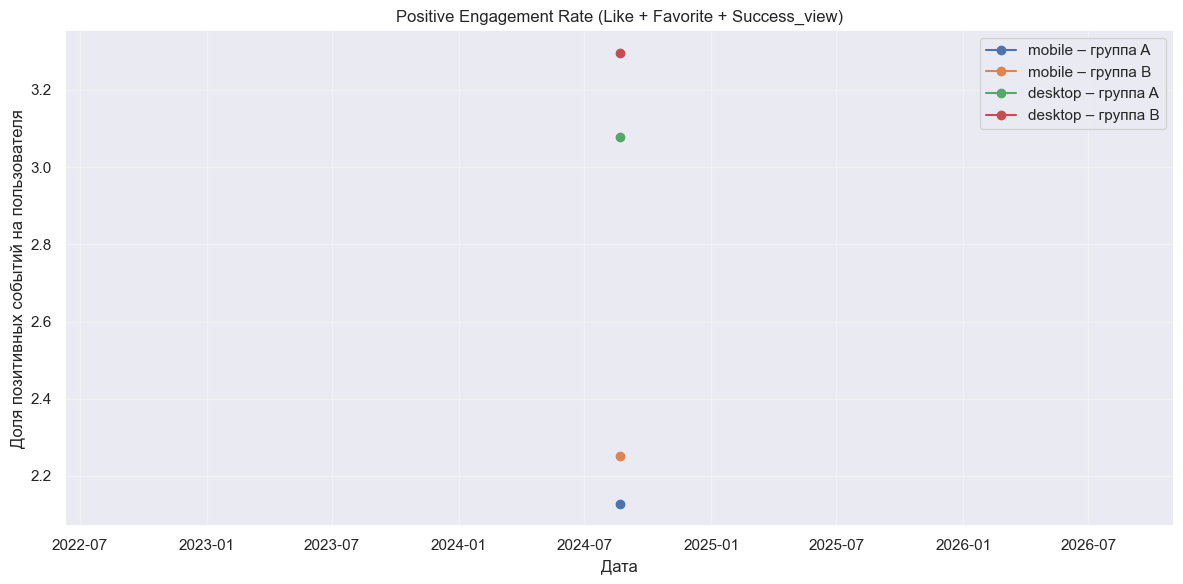

In [20]:
plt.figure(figsize=(12, 6))

for platform in eng_final['platform'].unique():
    for group in eng_final['exp_group'].unique():
        df_plot = eng_final[(eng_final['platform'] == platform) &
                            (eng_final['exp_group'] == group)]

        plt.plot(
            df_plot['dt_date'],
            df_plot['pos_rate'],
            marker='o',
            label=f'{platform} – группа {group.upper()}'
        )

plt.title('Positive Engagement Rate (Like + Favorite + Success_view)')
plt.xlabel('Дата')
plt.ylabel('Доля позитивных событий на пользователя')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

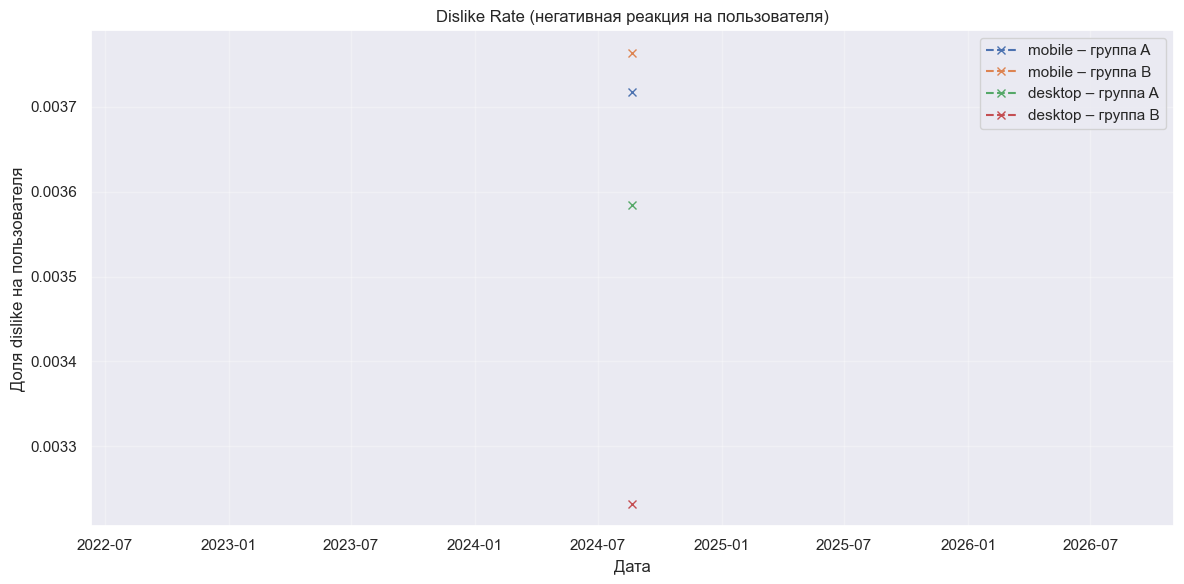

In [21]:
plt.figure(figsize=(12, 6))

for platform in eng_final['platform'].unique():
    for group in eng_final['exp_group'].unique():
        df_plot = eng_final[(eng_final['platform'] == platform) &
                            (eng_final['exp_group'] == group)]

        plt.plot(
            df_plot['dt_date'],
            df_plot['dislike_rate'],
            marker='x',
            linestyle='--',
            label=f'{platform} – группа {group.upper()}'
        )

plt.title('Dislike Rate (негативная реакция на пользователя)')
plt.xlabel('Дата')
plt.ylabel('Доля dislike на пользователя')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
del eng_final
gc.collect()

4408

## Average watch time per user-day

In [23]:
wt_events = data.loc[
    data['event_type'] == 'watch_time',
    ['dt_date', 'uid', 'exp_group', 'platform', 'watch_time']
].copy()

user_day = (
    data
    .groupby(['dt_date', 'uid', 'exp_group', 'platform'], observed=True)['watch_time']
    .sum()
    .reset_index(name='total_watch_time')   
)

del data
gc.collect()

user_day.head()

,dt_date,uid,exp_group,platform,total_watch_time
0,2024-08-21,295761658180,b,desktop,330
1,2024-08-21,2027736347293,b,mobile,120
2,2024-08-21,9030085535498,b,desktop,90
3,2024-08-21,11470170410993,b,mobile,90
4,2024-08-21,14292336968328,b,mobile,240


In [24]:
results_mean = {}

for plat in ['mobile', 'desktop']:
    df_p = user_day[user_day['platform'] == plat]

    a = df_p.loc[df_p['exp_group'] == 'a', 'total_watch_time'].to_numpy()
    b = df_p.loc[df_p['exp_group'] == 'b', 'total_watch_time'].to_numpy()

    stat, pval = stats.ttest_ind(a, b, equal_var=False)

    results_mean[plat] = {
        'n_a': len(a),
        'n_b': len(b),
        'mean_a': a.mean(),
        'mean_b': b.mean()
    }

results_mean

for plat, res in results_mean.items():
    print(f"\n=== {plat.upper()} — user-day level ===")
    print(f"A mean WT:  {res['mean_a']:.2f}")
    print(f"B mean WT:  {res['mean_b']:.2f}")


=== MOBILE — user-day level ===
A mean WT:  588.60
B mean WT:  587.72

=== DESKTOP — user-day level ===
A mean WT:  898.97
B mean WT:  905.43


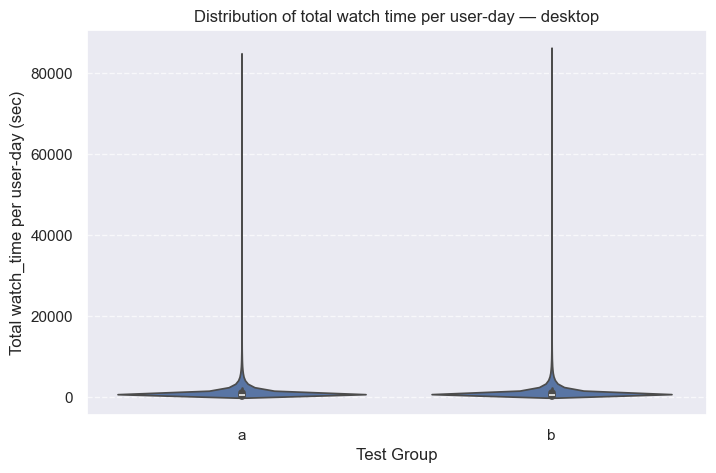

In [25]:
desktop_ud = user_day[user_day['platform'] == 'desktop']

plt.figure(figsize=(8, 5))
sns.violinplot(
    x="exp_group",
    y="total_watch_time",
    data=desktop_ud,
)

plt.title("Distribution of total watch time per user-day — desktop")
plt.xlabel("Test Group")
plt.ylabel("Total watch_time per user-day (sec)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

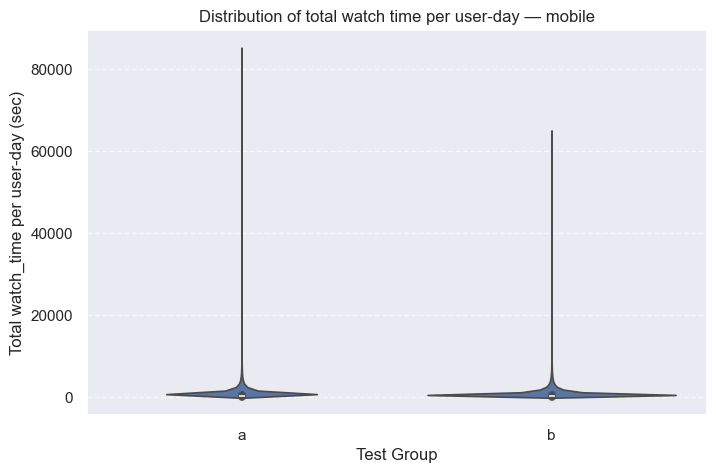

In [26]:
desktop_ud = user_day[user_day['platform'] == 'mobile']

plt.figure(figsize=(8, 5))
sns.violinplot(
    x="exp_group",
    y="total_watch_time",
    data=desktop_ud,
)

plt.title("Distribution of total watch time per user-day — mobile")
plt.xlabel("Test Group")
plt.ylabel("Total watch_time per user-day (sec)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Zero watch rate

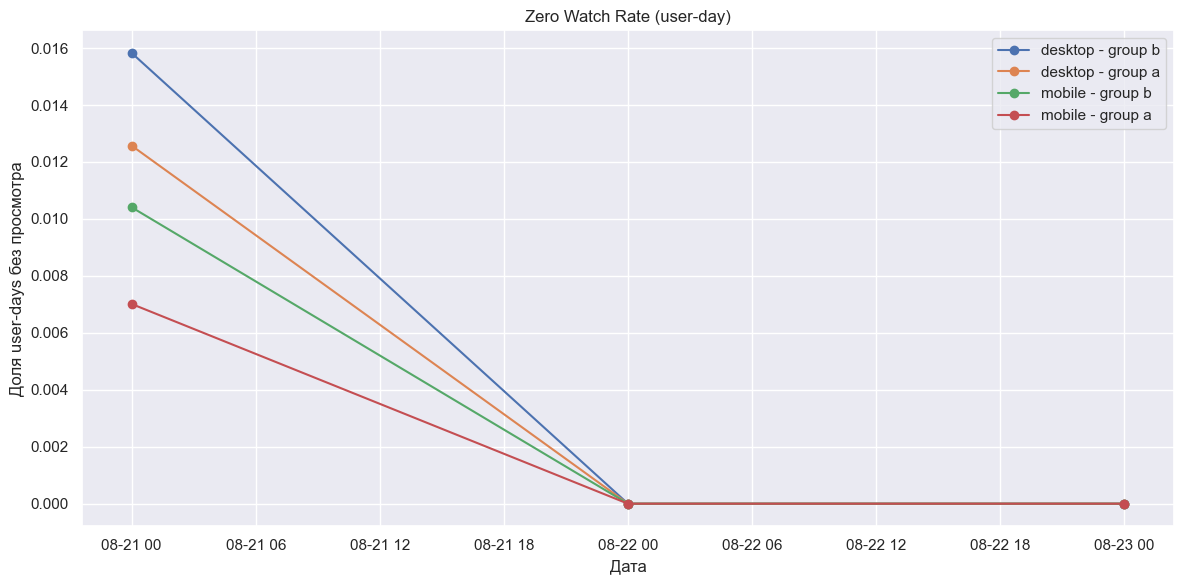

In [27]:
ud = user_day.copy()
ud['is_zero_watch'] = ud['total_watch_time'] == 0

zero_watch = (
    ud
    .groupby(['dt_date', 'exp_group', 'platform'], observed=True)
    .agg(
        total_users=('uid', 'nunique'),
        zero_watch_users=('is_zero_watch', 'sum'),
    )
    .assign(
        zero_watch_rate=lambda d: d['zero_watch_users'] / d['total_users']
    )
    .reset_index()
)

zero_watch

plt.figure(figsize=(12, 6))

for platform in zero_watch['platform'].unique():
    for group in zero_watch['exp_group'].unique():
        df_plot = zero_watch[
            (zero_watch['platform'] == platform) &
            (zero_watch['exp_group'] == group)
        ]
        plt.plot(
            df_plot['dt_date'],
            df_plot['zero_watch_rate'],
            marker='o',
            label=f"{platform} - group {group}"
        )

plt.title("Zero Watch Rate (user-day)")
plt.xlabel("Дата")
plt.ylabel("Доля user-days без просмотра")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Глубина просмотра

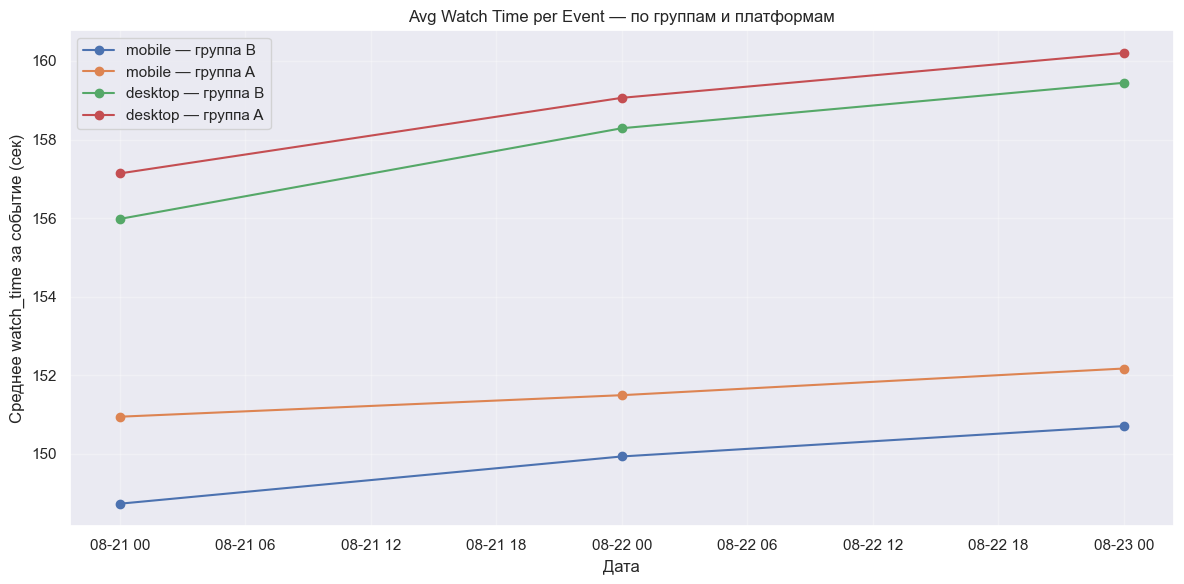

In [28]:
avg_wt_event = (
    wt_events
    .groupby(['dt_date', 'exp_group', 'platform'], observed=True)['watch_time']
    .agg(
        total_watch_time='sum',
        events_count='count',
        mean_watch_time='mean',
        median_watch_time='median'
    )
    .reset_index()
)

avg_wt_event['avg_watch_time_per_event'] = (
    avg_wt_event['total_watch_time'] / avg_wt_event['events_count']
)

avg_wt_event

plt.figure(figsize=(12, 6))

for platform in avg_wt_event['platform'].unique():
    subset = avg_wt_event[avg_wt_event['platform'] == platform]
    for group in subset['exp_group'].unique():
        df_plot = subset[subset['exp_group'] == group]

        plt.plot(
            df_plot['dt_date'],
            df_plot['avg_watch_time_per_event'],
            marker='o',
            label=f'{platform} — группа {group.upper()}'
        )

plt.title('Avg Watch Time per Event — по группам и платформам')
plt.xlabel('Дата')
plt.ylabel('Среднее watch_time за событие (сек)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
percentiles = (
    wt_events
    .groupby(['dt_date', 'exp_group', 'platform'], observed=True)['watch_time']
    .agg(
        p25=lambda x: np.percentile(x, 25),
        p50=lambda x: np.percentile(x, 50),
        p75=lambda x: np.percentile(x, 75),
        p90=lambda x: np.percentile(x, 90),
        p95=lambda x: np.percentile(x, 95),
        p99=lambda x: np.percentile(x, 99),
        count='count'
    )
    .reset_index()
)

percentiles

,dt_date,exp_group,platform,p25,p50,p75,p90,p95,p99,count
0,2024-08-21,b,mobile,30.0,90.0,180.0,330.0,450.0,810.0,18324942
1,2024-08-21,b,desktop,30.0,90.0,180.0,360.0,510.0,1020.0,6256431
2,2024-08-21,a,mobile,60.0,90.0,180.0,330.0,450.0,840.0,18089899
3,2024-08-21,a,desktop,30.0,90.0,180.0,360.0,510.0,1020.0,6149949
4,2024-08-22,b,mobile,60.0,90.0,180.0,330.0,450.0,840.0,20383615
5,2024-08-22,b,desktop,30.0,90.0,180.0,360.0,510.0,1050.0,6460051
6,2024-08-22,a,mobile,60.0,90.0,180.0,330.0,450.0,840.0,20172038
7,2024-08-22,a,desktop,30.0,90.0,180.0,360.0,510.0,1050.0,6342069
8,2024-08-23,b,mobile,60.0,90.0,180.0,330.0,450.0,840.0,21896097
9,2024-08-23,b,desktop,30.0,90.0,180.0,360.0,510.0,1080.0,6605853


## Количество видео на 1 юзера

=== Videos Watched per User-Day — Summary Table ===


,exp_group,platform,mean_videos,median_videos,user_days
0,b,desktop,5.763135,3.0,3352747
1,b,mobile,3.934889,2.0,15401873
2,a,desktop,5.683692,3.0,3340442
3,a,mobile,3.891771,2.0,15409396


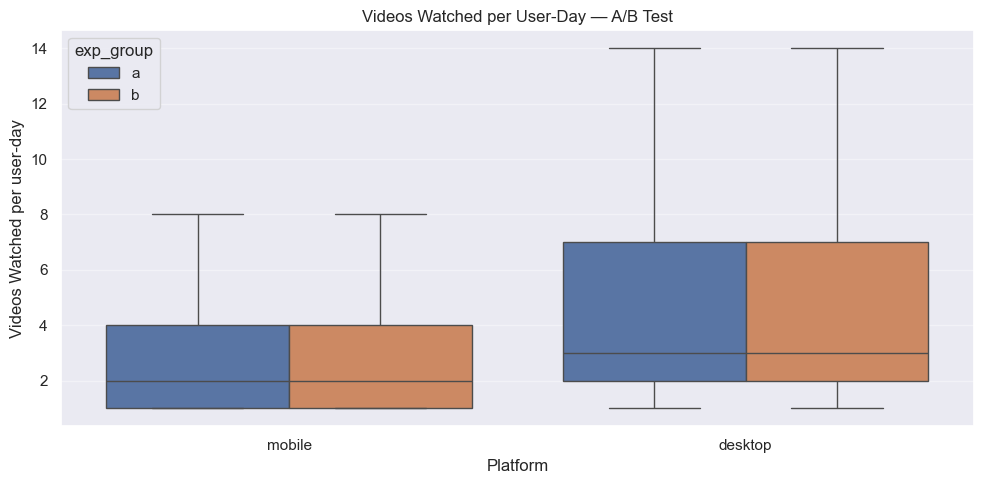

In [30]:
videos_per_user_day = (
    wt_events
    .groupby(['dt_date', 'uid', 'exp_group', 'platform'], observed=True)
    .size()
    .reset_index(name='videos_watched_day')
)

videos_stats_ud = (
    videos_per_user_day
    .groupby(['exp_group', 'platform'], observed=True)
    .agg(
        mean_videos=('videos_watched_day', 'mean'),
        median_videos=('videos_watched_day', 'median'),
        user_days=('uid', 'count')
    )
    .reset_index()
)

print("=== Videos Watched per User-Day — Summary Table ===")
display(videos_stats_ud)

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=videos_per_user_day,
    x='platform',
    y='videos_watched_day',
    hue='exp_group',
    showfliers=False
)

plt.title("Videos Watched per User-Day — A/B Test")
plt.xlabel("Platform")
plt.ylabel("Videos Watched per user-day")
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

# Experiment

## Среднее время просмотра на юзера в день

In [31]:
alpha = 0.05
beta = 0.2
metric_name = 'total_watch_time'   # user-day unit

mde_results = {}

for plat in ['mobile', 'desktop']:
    df_p = user_day[user_day['platform'] == plat]

    a = df_p[df_p['exp_group'] == 'a'][metric_name].to_numpy()
    b = df_p[df_p['exp_group'] == 'b'][metric_name].to_numpy()

    n_a, n_b = len(a), len(b)
    n_eff = int((n_a * n_b) / (n_a + n_b))   # эффективный размер

    std_pooled = np.sqrt((a.var(ddof=1) + b.var(ddof=1)) / 2)

    mde_abs = get_minimal_determinable_effect(
        std=std_pooled,
        sample_size=n_eff,
        alpha=alpha,
        beta=beta
    )

    baseline = a.mean()
    mde_rel = mde_abs / baseline

    mde_results[plat] = {
        'n_a': n_a,
        'n_b': n_b,
        'std_pooled': std_pooled,
        'baseline_mean_control': baseline,
        'mde_abs': mde_abs,
        'mde_rel': mde_rel,
    }

mde_results

{'mobile': {'n_a': 15443329,
  'n_b': 15452391,
  'std_pooled': 933.3099442477973,
  'baseline_mean_control': 588.5955277518209,
  'mde_abs': 1.3305328204021396,
  'mde_rel': 0.002260521457721904},
 'desktop': {'n_a': 3354398,
  'n_b': 3370420,
  'std_pooled': 1605.6848718754313,
  'baseline_mean_control': 898.9725447010164,
  'mde_abs': 4.90648228415489,
  'mde_rel': 0.005457877788455382}}

In [32]:
results_ud = {}

for plat in ['mobile', 'desktop']:
    df_p = user_day[user_day['platform'] == plat]

    control = df_p.loc[df_p['exp_group'] == 'a', 'total_watch_time'].to_numpy()
    pilot   = df_p.loc[df_p['exp_group'] == 'b', 'total_watch_time'].to_numpy()

    # t-test по user-day
    pvalue = stats.ttest_ind(control, pilot, equal_var=False).pvalue

    mean_a = control.mean()
    mean_b = pilot.mean()
    uplift = (mean_b - mean_a) / mean_a * 100

    results_ud[plat] = {
        'mean_a': mean_a,
        'mean_b': mean_b,
        'uplift_%': uplift,
        'pvalue': pvalue,
        'n_a': len(control),
        'n_b': len(pilot),
    }

print("=== 📱 MOBILE RESULTS (user-day) ===")
print(f"A mean WT per day:  {results_ud['mobile']['mean_a']:.2f}")
print(f"B mean WT per day:  {results_ud['mobile']['mean_b']:.2f}")
print(f"Uplift:             {results_ud['mobile']['uplift_%']:.2f}%")
print(f"P-value:            {results_ud['mobile']['pvalue']:.6f}")
print(f"N_a:                {results_ud['mobile']['n_a']}")
print(f"N_b:                {results_ud['mobile']['n_b']}")
print()

print("=== 🖥 DESKTOP RESULTS (user-day) ===")
print(f"A mean WT per day:  {results_ud['desktop']['mean_a']:.2f}")
print(f"B mean WT per day:  {results_ud['desktop']['mean_b']:.2f}")
print(f"Uplift:             {results_ud['desktop']['uplift_%']:.2f}%")
print(f"P-value:            {results_ud['desktop']['pvalue']:.6f}")
print(f"N_a:                {results_ud['desktop']['n_a']}")
print(f"N_b:                {results_ud['desktop']['n_b']}")

=== 📱 MOBILE RESULTS (user-day) ===
A mean WT per day:  588.60
B mean WT per day:  587.72
Uplift:             -0.15%
P-value:            0.008778
N_a:                15443329
N_b:                15452391

=== 🖥 DESKTOP RESULTS (user-day) ===
A mean WT per day:  898.97
B mean WT per day:  905.43
Uplift:             0.72%
P-value:            0.000000
N_a:                3354398
N_b:                3370420


## Среднее количество просмотров на юзера в день

In [33]:
# === Параметры теста ===
alpha = 0.05
beta = 0.2   # мощность 80%

mde_videos = {}

for plat in ['mobile', 'desktop']:
    df_p = videos_per_user_day[videos_per_user_day['platform'] == plat]

    a = df_p.loc[df_p['exp_group'] == 'a', 'videos_watched_day'].to_numpy()
    b = df_p.loc[df_p['exp_group'] == 'b', 'videos_watched_day'].to_numpy()

    # размеры выборок
    n_a, n_b = len(a), len(b)
    n_eff = int((n_a * n_b) / (n_a + n_b))   # гармонический размер

    # pooled std
    std_pooled = np.sqrt((a.var(ddof=1) + b.var(ddof=1)) / 2)

    # абсолютный MDE (в единицах метрики)
    mde_abs = get_minimal_determinable_effect(
        std=std_pooled,
        sample_size=n_eff,
        alpha=alpha,
        beta=beta
    )

    baseline = a.mean()
    mde_rel = mde_abs / baseline   # относительный эффект (в долях)

    mde_videos[plat] = {
        'n_a': n_a,
        'n_b': n_b,
        'n_eff': n_eff,
        'std_pooled': std_pooled,
        'baseline': baseline,
        'mde_abs': mde_abs,
        'mde_rel': mde_rel,
    }

for plat, res in mde_videos.items():
    print(f"\n=== {plat.upper()} — MDE for Videos per User-Day ===")
    print(f"Control mean (A): {res['baseline']:.4f} videos/day")
    print(f"Std pooled:       {res['std_pooled']:.4f}")
    print(f"n_a:              {res['n_a']}")
    print(f"n_b:              {res['n_b']}")
    print(f"n_effective:      {res['n_eff']}")
    print(f"MDE abs:          {res['mde_abs']:.4f} videos/day")
    print(f"MDE rel:          {res['mde_rel']*100:.2f}%")


=== MOBILE — MDE for Videos per User-Day ===
Control mean (A): 3.8918 videos/day
Std pooled:       5.2994
n_a:              15409396
n_b:              15401873
n_effective:      7702816
MDE abs:          0.0076 videos/day
MDE rel:          0.19%

=== DESKTOP — MDE for Videos per User-Day ===
Control mean (A): 5.6837 videos/day
Std pooled:       7.6726
n_a:              3340442
n_b:              3352747
n_effective:      1673291
MDE abs:          0.0235 videos/day
MDE rel:          0.41%


In [34]:
results_videos = {}

for plat in ['mobile', 'desktop']:
    df_p = videos_per_user_day[videos_per_user_day['platform'] == plat]

    a = df_p.loc[df_p['exp_group'] == 'a', 'videos_watched_day'].to_numpy()
    b = df_p.loc[df_p['exp_group'] == 'b', 'videos_watched_day'].to_numpy()

    stat, pval = ttest_ind(a, b, equal_var=False)

    results_videos[plat] = {
        'n_a_user_days': len(a),
        'n_b_user_days': len(b),
        'mean_a': a.mean(),
        'mean_b': b.mean(),
        'uplift_%': (b.mean() / a.mean() - 1) * 100,
        'stat': stat,
        'pval': pval,
    }

for plat, res in results_videos.items():
    print(f"\n=== {plat.upper()} — Videos per User-Day ===")
    print(f"A mean videos/day:  {res['mean_a']:.3f}")
    print(f"B mean videos/day:  {res['mean_b']:.3f}")
    print(f"Uplift:             {res['uplift_%']:.2f}%")
    print(f"P-value:            {res['pval']:.6f}")


=== MOBILE — Videos per User-Day ===
A mean videos/day:  3.892
B mean videos/day:  3.935
Uplift:             1.11%
P-value:            0.000000

=== DESKTOP — Videos per User-Day ===
A mean videos/day:  5.684
B mean videos/day:  5.763
Uplift:             1.40%
P-value:            0.000000


## Средняя глубина просмотра видео на юзера в день

In [35]:
alpha = 0.05
beta = 0.2

# Метрика, по которой считаем MDE
metric = 'avg_watch_time_per_event'

mde_depth = {}

for plat in ['mobile', 'desktop']:

    df_p = avg_wt_event[avg_wt_event['platform'] == plat]

    a = df_p[df_p['exp_group'] == 'a'][metric].to_numpy()
    b = df_p[df_p['exp_group'] == 'b'][metric].to_numpy()

    n_a, n_b = len(a), len(b)

    # эффективный размер выборки
    n_eff = int((n_a * n_b) / (n_a + n_b))

    # pooled std
    std_pooled = np.sqrt((a.var(ddof=1) + b.var(ddof=1)) / 2)

    mde_abs = get_minimal_determinable_effect(
        std=std_pooled,
        sample_size=n_eff,
        alpha=alpha,
        beta=beta
    )

    baseline = a.mean()
    mde_rel = mde_abs / baseline * 100

    mde_depth[plat] = {
        'n_a': n_a,
        'n_b': n_b,
        'std_pooled': std_pooled,
        'baseline_mean_control': baseline,
        'mde_absolute': mde_abs,
        'mde_relative_%': mde_rel
    }

for plat, res in mde_depth.items():
    print(f"\n=== {plat.upper()} — MDE for avg_watch_time_per_event ===")
    print(f"Control mean:       {res['baseline_mean_control']:.4f} sec")
    print(f"Pooled STD:         {res['std_pooled']:.4f}")
    print(f"Sample sizes:       A={res['n_a']}, B={res['n_b']}")
    print(f"MDE (absolute):     {res['mde_absolute']:.4f} sec")
    print(f"MDE (relative):     {res['mde_relative_%']:.2f}%")



=== MOBILE — MDE for avg_watch_time_per_event ===
Control mean:       151.5373 sec
Pooled STD:         0.8271
Sample sizes:       A=3, B=3
MDE (absolute):     3.2772 sec
MDE (relative):     2.16%

=== DESKTOP — MDE for avg_watch_time_per_event ===
Control mean:       158.7997 sec
Pooled STD:         1.6601
Sample sizes:       A=3, B=3
MDE (absolute):     6.5772 sec
MDE (relative):     4.14%


In [36]:
results_depth = {}

for plat in ['mobile', 'desktop']:

    df_p = avg_wt_event[avg_wt_event['platform'] == plat]

    control = df_p.loc[df_p['exp_group'] == 'a', 'avg_watch_time_per_event'].to_numpy()
    pilot   = df_p.loc[df_p['exp_group'] == 'b', 'avg_watch_time_per_event'].to_numpy()

    pvalue = ttest_ind(control, pilot, equal_var=False).pvalue

    mean_a = control.mean()
    mean_b = pilot.mean()
    uplift = (mean_b - mean_a) / mean_a * 100

    results_depth[plat] = {
        'mean_a': mean_a,
        'mean_b': mean_b,
        'uplift_%': uplift,
        'pvalue': pvalue
    }

for plat in results_depth:
    res = results_depth[plat]
    print(f"\n=== {plat.upper()} — depth per event (avg_watch_time_per_event) ===")
    print(f"A mean:      {res['mean_a']:.4f} sec")
    print(f"B mean:      {res['mean_b']:.4f} sec")
    print(f"Uplift:      {res['uplift_%']:.2f}%")
    print(f"P-value:     {res['pvalue']:.6f}")


=== MOBILE — depth per event (avg_watch_time_per_event) ===
A mean:      151.5373 sec
B mean:      149.7912 sec
Uplift:      -1.15%
P-value:     0.073219

=== DESKTOP — depth per event (avg_watch_time_per_event) ===
A mean:      158.7997 sec
B mean:      157.9027 sec
Uplift:      -0.56%
P-value:     0.544827


In [37]:
del avg_wt_event, df_p, user_day, videos_per_user_day, wt_events, videos_stats_ud, zero_watch
gc.collect()

8404